# Importing the Libraries

In [26]:
!pip install fuzzywuzzy

In [2]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
from fuzzywuzzy import fuzz
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# Loading the Dataset

In [3]:
df = pd.read_json('Magazine_Subscriptions.json', lines=True)
df.head()

,overall,vote,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,style,image
0,5,9,False,"11 8, 2001",AH2IFH762VY5U,B00005N7P0,ted sedlmayr,"for computer enthusiast, MaxPC is a welcome si...","AVID READER SINCE ""boot"" WAS THE NAME",1005177600,NaN,NaN
1,5,9,False,"10 31, 2001",AOSFI0JEYU4XM,B00005N7P0,Amazon Customer,Thank god this is not a Ziff Davis publication...,The straight scoop,1004486400,NaN,NaN
2,3,14,False,"03 24, 2007",A3JPFWKS83R49V,B00005N7OJ,Bryan Carey,Antiques Magazine is a publication made for an...,"Antiques Magazine is Good, but not for Everyone",1174694400,{'Format:': ' Print Magazine'},NaN
3,5,13,False,"11 10, 2006",A19FKU6JZQ2ECJ,B00005N7OJ,Patricia L. Porada,This beautiful magazine is in itself a work of...,THE DISCERNING READER,1163116800,{'Format:': ' Print Magazine'},NaN
4,5,NaN,True,"07 14, 2014",A25MDGOMZ2GALN,B00005N7P0,Alvey,A great read every issue.,Five Stars,1405296000,NaN,NaN


# Data Exploration

In [4]:
df = df.loc[:, ['reviewerID', 'asin', 'overall']] # selecting relevant features

In [5]:
df = df.dropna(how='any', axis=0) # dropping rows containing null values

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 89689 entries, 0 to 89688
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reviewerID  89689 non-null  object
 1   asin        89689 non-null  object
 2   overall     89689 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.7+ MB


In [7]:
df_overall_count = pd.DataFrame(df.groupby('overall').size(), columns=['count'])
df_overall_count

,count
overall,
1,11029
2,5223
3,6971
4,12676
5,53790


Text(0, 0.5, 'count of each overall score')

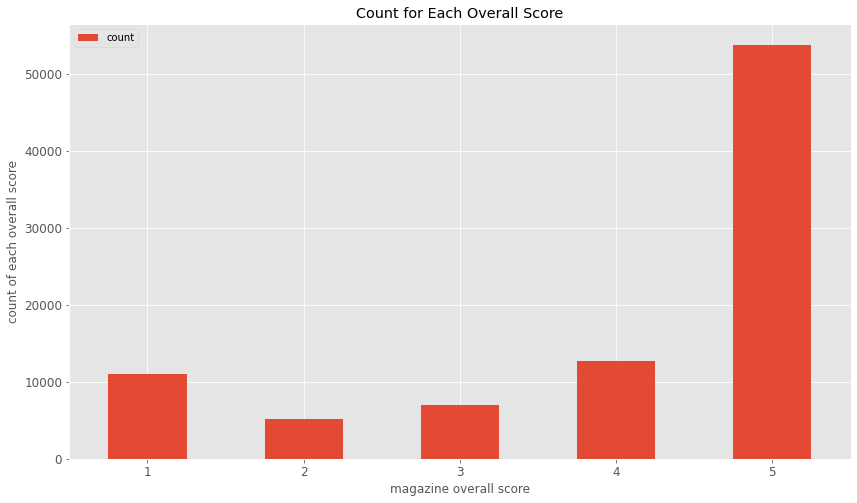

In [8]:
ax = df_overall_count.reset_index().plot(
    x='overall',
    y='count',
    kind='bar',
    figsize=(14, 8),
    title='Count for Each Overall Score',
    fontsize=12,
)
plt.xticks(rotation=0)
ax.set_xlabel("magazine overall score")
ax.set_ylabel("count of each overall score")

In [9]:
df_asin_count = pd.DataFrame(df.groupby('asin').size(), columns=['count'])
df_asin_count.head()

,count
asin,
B00005N7NQ,117
B00005N7O3,5
B00005N7O4,6
B00005N7O6,64
B00005N7O9,23


Text(0, 0.5, 'number of overall scores')

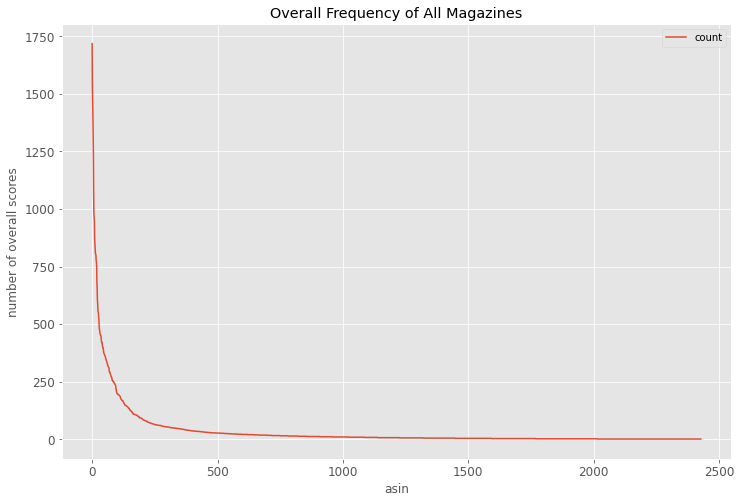

In [10]:
# plotting overall frequency of all asin values
ax = df_asin_count.sort_values('count', ascending=False).reset_index(drop=True).plot(
                                                                    figsize=(12, 8),
                                                                    title='Overall Frequency of All Magazines',
                                                                    fontsize=12
    )
ax.set_xlabel("asin")
ax.set_ylabel("number of overall scores")

In [11]:
# distribution of overall scores by asin values
df_asin_count['count'].quantile(np.arange(1, 0.6, -0.05))

1.00    1718.0
0.95     168.0
0.90      66.3
0.85      43.0
0.80      28.0
0.75      21.0
0.70      16.0
0.65      13.0
Name: count, dtype: float64

In [12]:
df_reviewers_count = pd.DataFrame(df.groupby('reviewerID').size(), columns=['count'])
df_reviewers_count.head()

,count
reviewerID,
A0068533X8Y5TYUJWWIC,1
A02292976AOUT3I4ZLFA,1
A0328927TA7ECTIKNP3G,1
A0333047WGK24IZKLDP2,1
A0479411TZTHITJ9TFB8,1


Text(0, 0.5, 'number of overall scores')

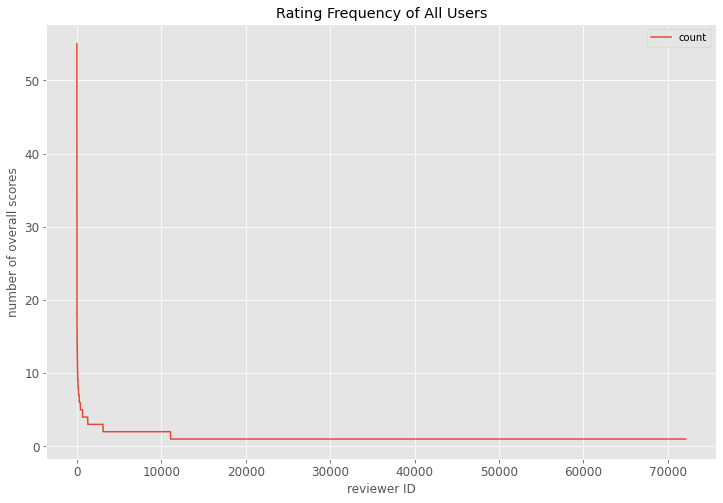

In [13]:
# plotting overall frequency of all reviewers
ax = df_reviewers_count.sort_values('count', ascending=False).reset_index(drop=True).plot(
                                                                    figsize=(12, 8),
                                                                    title='Rating Frequency of All Users',
                                                                    fontsize=12
    )
ax.set_xlabel("reviewer ID")
ax.set_ylabel("number of overall scores")

In [14]:
# distribution of overall scores by reviewers
df_reviewers_count['count'].quantile(np.arange(1, 0.5, -0.05))

1.00    55.0
0.95     2.0
0.90     2.0
0.85     2.0
0.80     1.0
0.75     1.0
0.70     1.0
0.65     1.0
0.60     1.0
0.55     1.0
Name: count, dtype: float64

# Building Item-Based Collaborative Filtering Recommender System With Cosine Similarity

## Data Preprocessing

In [15]:
num_users = len(df.reviewerID.unique())
num_items = len(df.asin.unique())
print('There are {} unique reviewers and {} unique magazines in this dataset'.format(num_users, num_items))

There are 72098 unique reviewers and 2428 unique magazines in this dataset


In [16]:
df.drop_duplicates(ignore_index=True, inplace=True) # dropping duplicate rows

In [17]:
le = LabelEncoder()
df['productid'] = le.fit_transform(df['asin']) # converting categorical feature to numeric

In [18]:
asin_user_mat = df.pivot_table(index='productid', columns='reviewerID', values='overall').fillna(0)

In [19]:
asin_user_mat_sparse = csr_matrix(asin_user_mat.values)

In [20]:
asin_to_idx = {
    asin: i for i, asin in 
    enumerate(list(df.set_index('productid').loc[asin_user_mat.index].asin))
}

## Model Training

In [21]:
def fuzzy_matching(mapper, fav_magazine, verbose=True):
    match_tuple = []

    for asin, idx in mapper.items():
        ratio = fuzz.ratio(asin.lower(), fav_magazine.lower())
        if ratio >= 60:
            match_tuple.append((asin, idx, ratio))

    match_tuple = sorted(match_tuple, key=lambda x: x[2])[::-1]
    if not match_tuple:
        print('No match is found')
        return
    if verbose:
        print('Found possible matches in our database: {0}\n'.format([x[0] for x in match_tuple]))
    return match_tuple[0][1]

In [22]:
model_knn = NearestNeighbors(n_neighbors=1,  algorithm='brute', metric='cosine', n_jobs=-1)
model_knn.fit(asin_user_mat_sparse)

NearestNeighbors(algorithm='brute', metric='cosine', n_jobs=-1, n_neighbors=1)

In [23]:
favourite_magazine = 'B00005N7P0' 
model_knn.fit(asin_user_mat_sparse) # training

NearestNeighbors(algorithm='brute', metric='cosine', n_jobs=-1, n_neighbors=1)

## Making Recommendations

In [24]:
idx = fuzzy_matching(asin_to_idx, favourite_magazine, verbose=False)
distances, indices = model_knn.kneighbors(asin_user_mat_sparse[idx], n_neighbors=6)
raw_recommends = sorted(list(zip(indices.squeeze().tolist(), distances.squeeze().tolist())), key=lambda x: x[1])[:0:-1]
reverse_mapper = {v: k for k, v in asin_to_idx.items()}

In [25]:
print('\nInput Magazine:', favourite_magazine)
print('\nRecommendations for users who also browsed {}:\n'.format(favourite_magazine))
for i, (idx, dist) in enumerate(raw_recommends):
    print('{0}: {1}, with cosine distance of {2}'.format(i+1, df[df['productid'] == idx]['asin'].values[0], dist))


Input Magazine: B00005N7P0

Recommendations for users who also browsed B00005N7P0:

1: B00005N7UC, with cosine distance of 0.971007245181458
2: B00005Q7E7, with cosine distance of 0.9629139658390499
3: B00005UQ65, with cosine distance of 0.9619186392981828
4: B0032KHQXO, with cosine distance of 0.9341047244023177
5: B000F2BVK6, with cosine distance of 0.898123275037932
